# TASK 6.6: Sourcing & Analysing Time-Series Data

## This script contain:
### 1. Importing Libraries & Data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing COVID-19 Data
### 6. Defining Parameters
### 7. Splitting the Data
### 8. Running and Fitting the Model
### 9. Iterating

## 1. Importing Libraries & Data

### Libraries

In [1]:
# import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm 
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

### Data

In [2]:
# Configure API key
quandl.ApiConfig.api_key = 'mott9gxfQT9c-KacZszV'

In [3]:
# Importing the Energy Production and Consumption Data "Carbon Dioxide (CO2) Emmissions - South Africa" variable.
# This dataset and variable has nothing to do with my current dataset, but since COVID-19 only started in 2019
# there is not enough datapoints.
# I chose this variable since I am from South Africa and CO2 emmisions are not only bad for the environment but also for our health
data = quandl.get('BP/C02_EMMISSIONS_ZAF')

In [4]:
data.head()

,Value
Date,
1965-12-31,113.204194
1966-12-31,113.521913
1967-12-31,116.842666
1968-12-31,123.105197
1969-12-31,126.252080


In [5]:
data.shape

(56, 1)

# For this task I would like to do time-series analysis of two variables in my dataset: total vaccinations and total deaths

## 2. Subsetting, wrangling, and cleaning time-series data

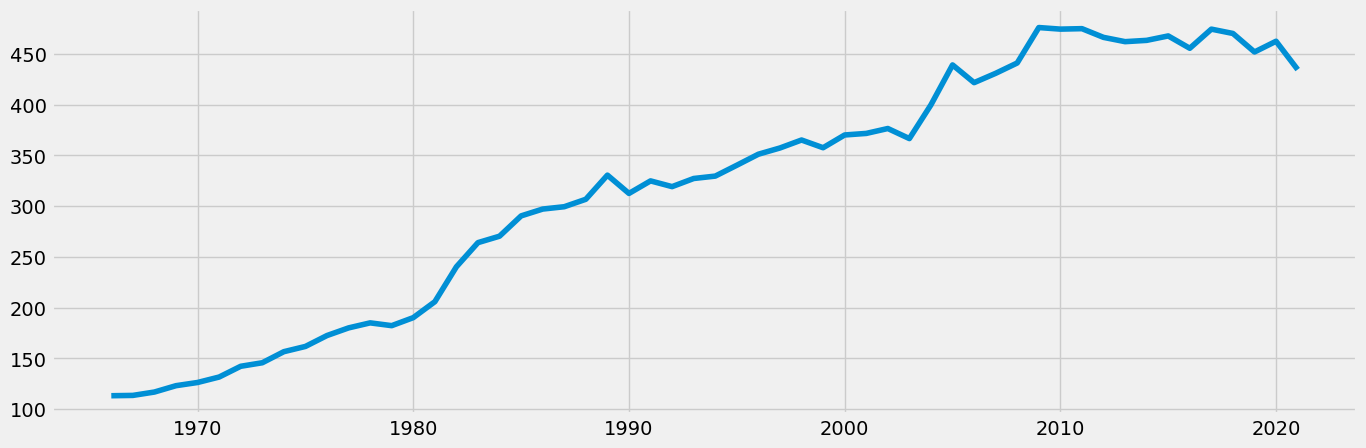

In [6]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

I don't think it is necessary to create a subset of the data. It does not look as though the trend really changes. Maybe from 2010. I will see how it goes.

In [7]:
# check for missing values
data.isnull().sum()
# no missing values

Value    0
dtype: int64

In [8]:
# Check for duplicates
dups = data.duplicated()
dups.sum()
# no duplicates

0

## 3. Time-series analysis: decomposition

In [9]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [10]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

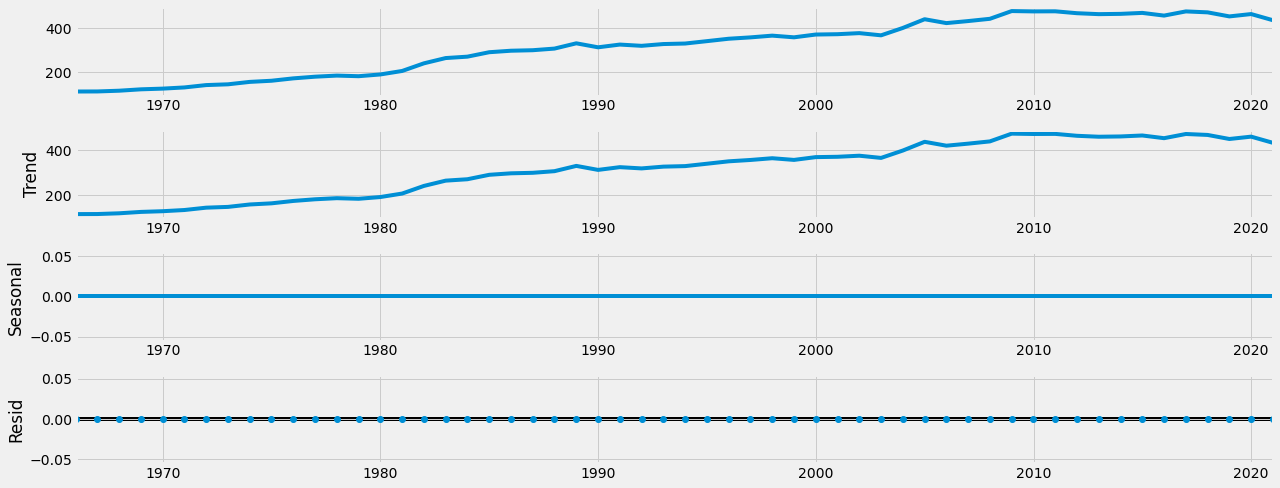

In [11]:
# Plot the separate components
decomposition.plot()
plt.show()

The first chart is the 'level', or the data with all its compositions - this shows a very gradual increase from 1965.

The second chart indicates the 'trend' of the data. This data shows a gradual upward trend with a plauteau from around 2010 and maybe a hint of decreasing trend from the end of 2019.

The third chart indicates 'seasonality'. This data does not have any seasonality.

The last chart is residual noise.

## 4. Testing for Stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):

    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.628989
p-value                         0.468020
Number of Lags Used             0.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


My Test Statistic is larger than the Critical Value, thus the null hypothesis cannot be rejected and the data is not stationary.

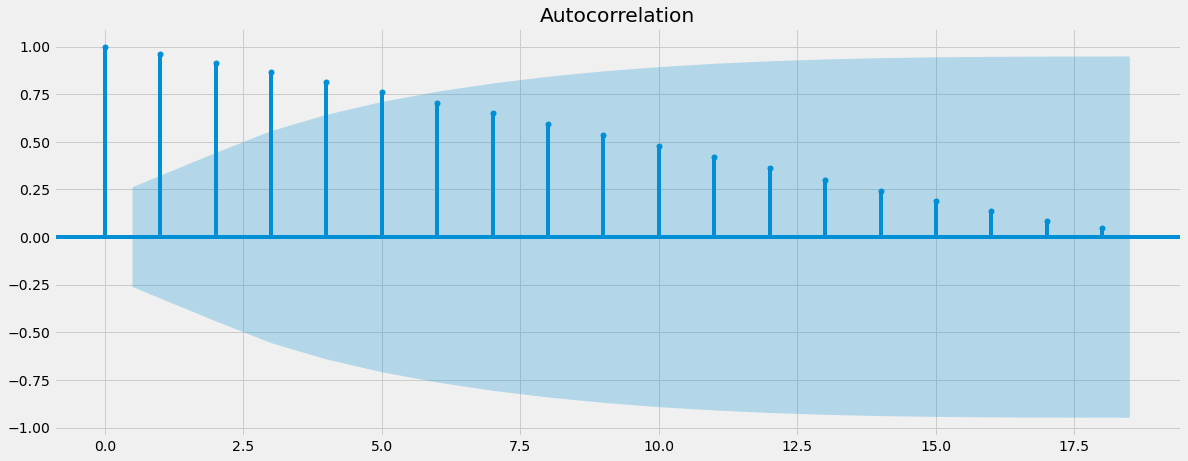

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data)
plt.show()

According to this graph there are a few autocorrelations in the dataset and it is likely not stationary which supports the dicky fuller test.

## 5. Stationarizing CO2 Emmision data

In [37]:
df_diff = data - data.shift(1)

In [38]:
df_diff.dropna(inplace = True)

In [39]:
df_diff.head()

,Value
Date,
1966-12-31,0.317719
1967-12-31,3.320753
1968-12-31,6.262531
1969-12-31,3.146883
1970-12-31,5.369620


In [40]:
df_diff.tail()

,Value
Date,
2016-12-31,18.853003
2017-12-31,-4.266281
2018-12-31,-18.248158
2019-12-31,10.575768
2020-12-31,-27.905021


In [41]:
df_diff.columns

Index(['Value'], dtype='object')

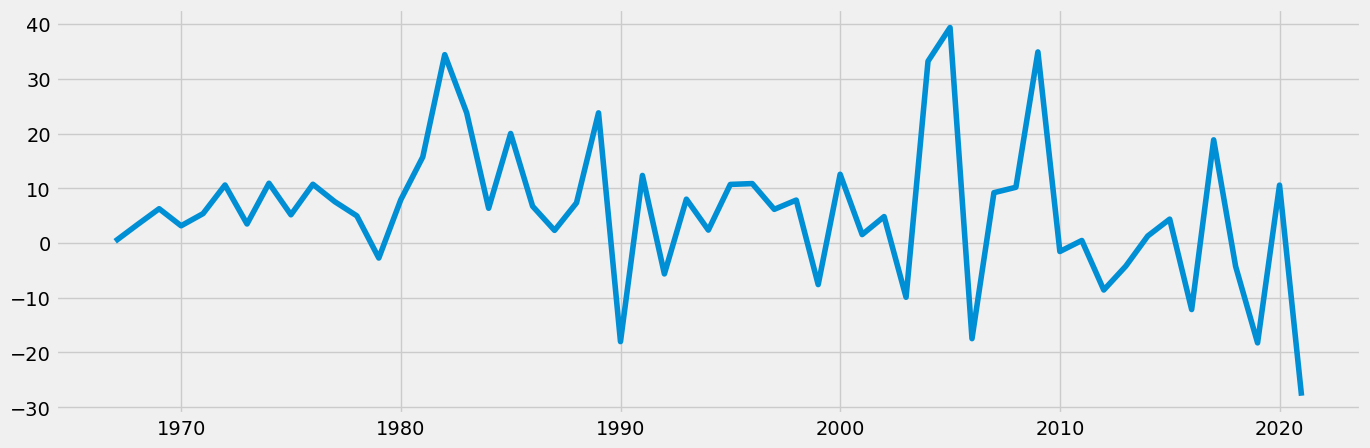

In [42]:
# Check what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [43]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.160597e+00
p-value                        2.975144e-10
Number of Lags Used            0.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


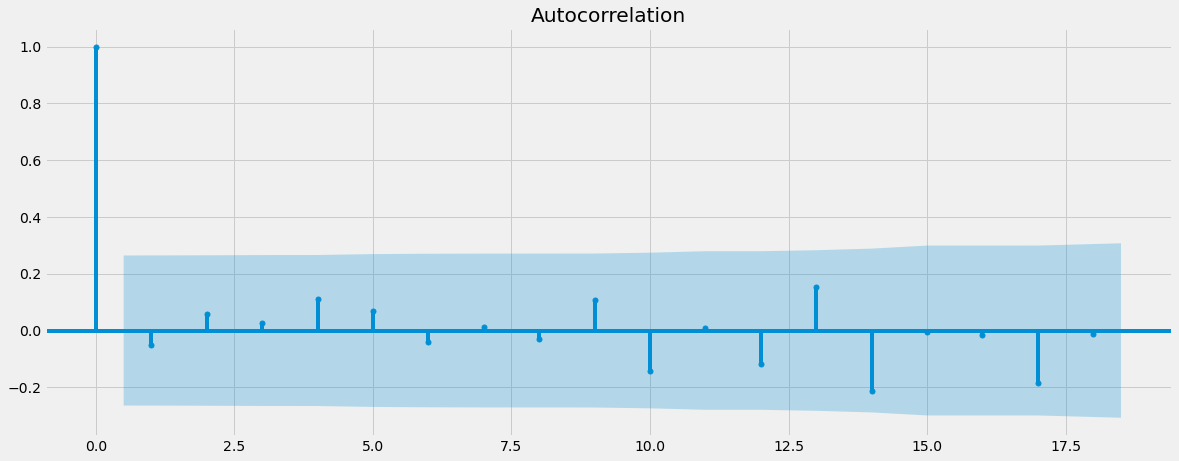

In [44]:
plot_acf(df_diff)
plt.show()

Now the Test Statistic is far smaller than the critical Value and the graph above doesn't show _any significant_ autocorrelation. This means the differencing was sufficient and the data is ready for forecasting.

# Bonus Task

## 6. Defining Parameters

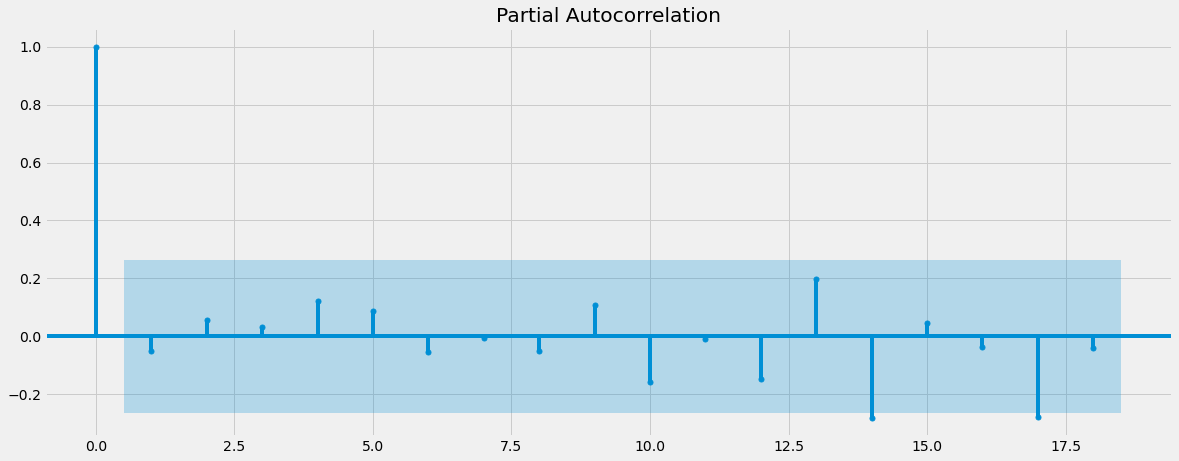

<Figure size 4500x4500 with 0 Axes>

In [22]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(df_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

On this plot, there is a significant correlation at lag 1 followed by correlations that are not significant. This pattern indicates an autoregressive term of order 1.

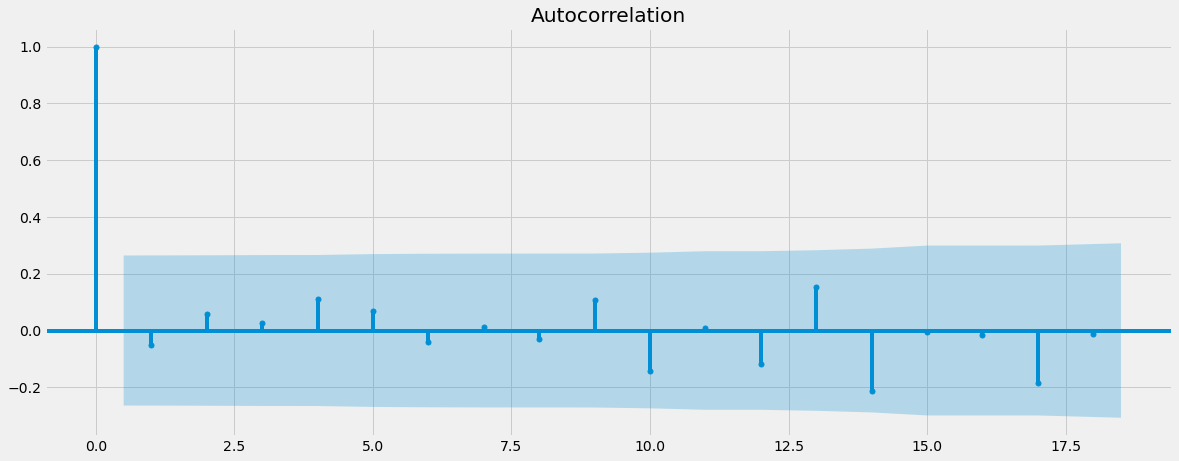

<Figure size 1500x500 with 0 Axes>

In [23]:
# Plot autocorrelations to determine parameter q
plot_acf(df_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

## 7. Splitting the Data

In [24]:
# Split the data
train = df_diff['Value'][:41]
test = df_diff['Value'][40:]

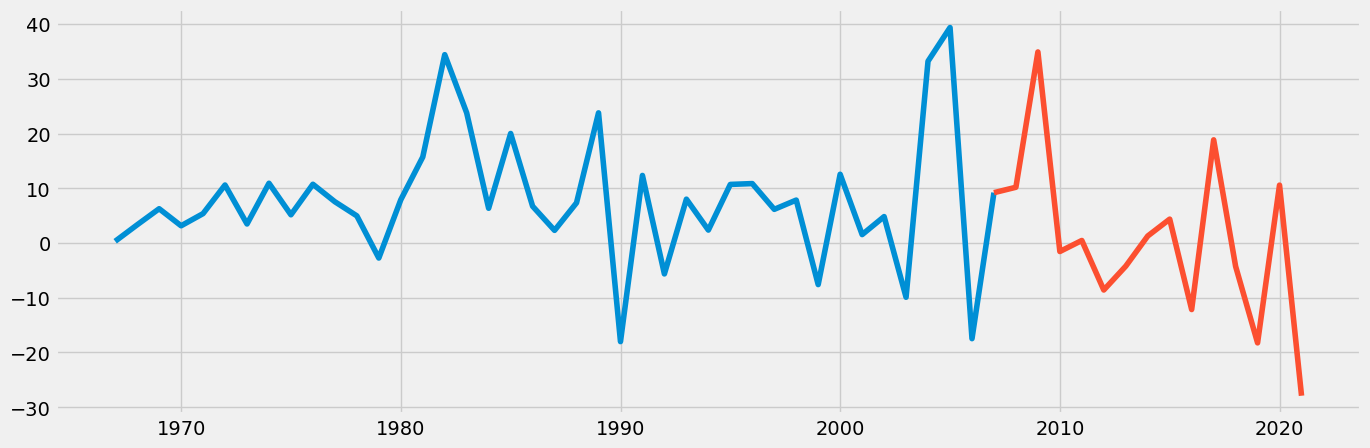

In [25]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [26]:
test.shape

(15,)

## 8. Running and Fitting the Model

In [27]:
from statsmodels.tsa.api import ARIMA

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   40
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -157.227
Method:                       css-mle   S.D. of innovations             11.748
Date:                Thu, 14 Apr 2022   AIC                            322.454
Time:                        14:46:18   BIC                            329.209
Sample:                    12-31-1967   HQIC                           324.897
                         - 12-31-2006                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.146      0.129      0.897      -0.268       0.305
ar.L1.D.Value    -0.0655      0.158     -0.414      0.679      -0.375       0.244
ma.L1.D.Value    -1.0000      0.079    -

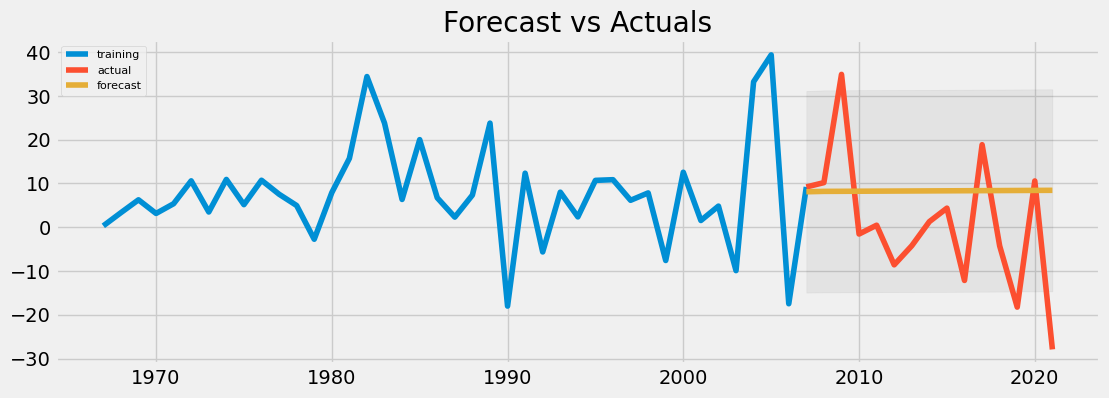

In [28]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   40
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -156.810
Method:                       css-mle   S.D. of innovations             11.475
Date:                Thu, 14 Apr 2022   AIC                            325.620
Time:                        14:53:07   BIC                            335.753
Sample:                    12-31-1967   HQIC                           329.283
                         - 12-31-2006                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0202      0.143      0.141      0.888      -0.261       0.301
ar.L1.D.Value    -1.0250      0.158     -6.504      0.000      -1.334      -0.716
ar.L2.D.Value    -0.1036      0.159     

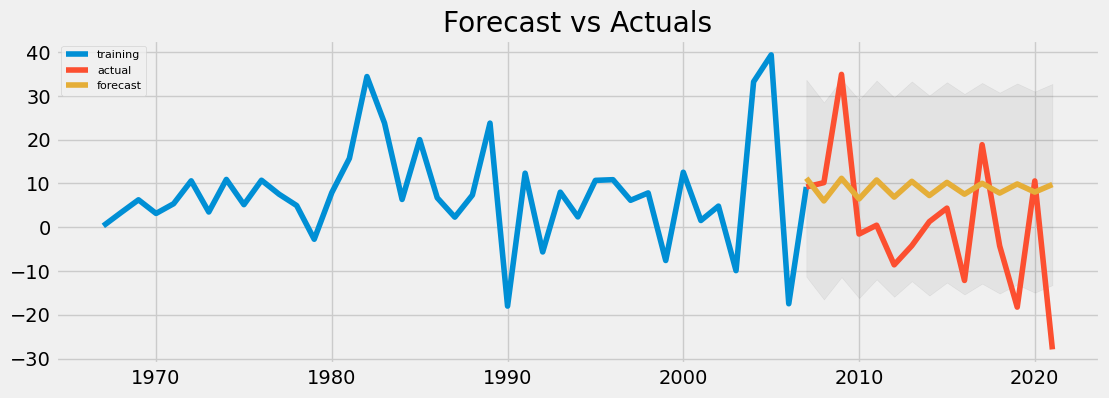

In [50]:
model = ARIMA(train, order=(2, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()